### Import libraries and sub-libraries

In [20]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
import math
import random
import traceback
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

### Font setting

In [21]:
try:
    from fontsetting import font_cmu
    plt = font_cmu(plt)
except ImportError:
    print("Custom font setting 'fontsetting.py' not found. Using default fonts.")
    pass

### Configuration & Hyperparameters

In [ ]:
# Data Paths
TRAIN_HIGH_RES_DIR = 'data/train/high-res'
TRAIN_LOW_RES_DIR = 'data/train/low-res'
VAL_HIGH_RES_DIR = 'data/val/high-res'
VAL_LOW_RES_DIR = 'data/val/low-res'

# Model Saving
MODEL_SAVE_PATH = 'best_model.pth'

# Training Settings
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 8 # Keep low for large images if memory constrained
LEARNING_RATE = 1e-4 # Adjusted LR, tune as needed
NUM_EPOCHS = 100 # Increased epochs for scheduler/convergence
LOSS_ALPHA = 0.5 # Weight for SSIM component in loss

# --- LR Scheduler Settings ---
SCHEDULER_FACTOR = 0.1 # Factor by which the learning rate will be reduced
SCHEDULER_PATIENCE = 5  # Number of epochs with no improvement after which learning rate will be reduced
SCHEDULER_THRESHOLD = 1e-4 # Threshold for measuring the new optimum, to only focus on significant changes
SCHEDULER_MIN_LR = 1e-7 # Lower bound on the learning rate

# --- Experiment Tracking ---
TENSORBOARD_LOG_DIR = "runs/trivialnet_experiment" # Base directory for TensorBoard logs

# --- Reproducibility ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    # May add these for further determinism, but can impact performance
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

print(f'Device available: {DEVICE}')
print(f'Batch Size: {BATCH_SIZE}')
print(f'Initial Learning Rate: {LEARNING_RATE}')
print(f'Number of Epochs: {NUM_EPOCHS}')
print(f'Loss Alpha (Weight for 1-SSIM): {LOSS_ALPHA}')
print(f"TensorBoard Log Directory: {TENSORBOARD_LOG_DIR}")

Device available: cuda
Batch Size: 1
Initial Learning Rate: 0.0001
Number of Epochs: 50
Loss Alpha (Weight for 1-SSIM): 0.5
TensorBoard Log Directory: runs/trivialnet_experiment


### Data Loading and Transformations

In [ ]:
class TIFFDataset(Dataset):
    def __init__(self, high_res_dir, low_res_dir, mode='train'):
        self.high_res_dir = high_res_dir
        self.low_res_dir = low_res_dir
        self.mode = mode # Store the mode (train/val)

        # Validate mode
        if self.mode not in ['train', 'val']:
            raise ValueError("Mode must be 'train' or 'val'")

        try:
            self.high_res_filenames = sorted([f for f in os.listdir(high_res_dir) if f.endswith('.tif')])
            self.low_res_filenames = sorted([f for f in os.listdir(low_res_dir) if f.endswith('.tif')])
        except FileNotFoundError as e:
            print(f"Error: Directory not found - {e}. Please check data paths.")
            raise

        if len(self.high_res_filenames) != len(self.low_res_filenames):
            raise ValueError("Mismatch in number of high-res and low-res files.")
        if self.high_res_filenames != self.low_res_filenames:
            print("Warning: File names in high-res and low-res directories do not perfectly match. Assuming correspondence by sorted order.")
        self.filenames = self.high_res_filenames

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        high_res_path = os.path.join(self.high_res_dir, self.filenames[idx])
        low_res_path = os.path.join(self.low_res_dir, self.filenames[idx])

        try:
            # 1. Load images using PIL
            high_res_img_pil = Image.open(high_res_path)
            low_res_img_pil = Image.open(low_res_path)

            # 2. Ensure target sizes using PIL resize
            target_high_res_size = (256, 256) # H, W
            target_low_res_size = (128, 128) # H, W

            # Resize high-res if necessary (ensure mode 'F' is handled if applicable)
            # Assuming images are now properly loaded (e.g., as 'L' or scaled 'F')
            if high_res_img_pil.mode == 'F':
                 high_res_np = np.array(high_res_img_pil, dtype=np.float32)
                 min_val, max_val = high_res_np.min(), high_res_np.max()
                 if max_val > min_val: high_res_np = (high_res_np - min_val) / (max_val - min_val)
                 high_res_img_pil = Image.fromarray((high_res_np * 255).astype(np.uint8)) # Convert scaled float back to uint8 PIL for resize/ToTensor
            elif high_res_img_pil.mode != 'L':
                 high_res_img_pil = high_res_img_pil.convert('L') # Ensure L mode if not F

            if high_res_img_pil.size != target_high_res_size[::-1]:
                high_res_img_pil = high_res_img_pil.resize(target_high_res_size[::-1], Image.BICUBIC)

            # Resize low-res (ensure mode 'F' handled)
            if low_res_img_pil.mode == 'F':
                 low_res_np = np.array(low_res_img_pil, dtype=np.float32)
                 min_val, max_val = low_res_np.min(), low_res_np.max()
                 if max_val > min_val: low_res_np = (low_res_np - min_val) / (max_val - min_val)
                 low_res_img_pil = Image.fromarray((low_res_np * 255).astype(np.uint8))
            elif low_res_img_pil.mode != 'L':
                 low_res_img_pil = low_res_img_pil.convert('L')

            low_res_img_pil_resized = low_res_img_pil.resize(target_low_res_size[::-1], Image.BICUBIC)

            # 3. Convert PIL images to Tensors -> Scales to [0.0, 1.0]
            low_res_tensor = TF.to_tensor(low_res_img_pil_resized)
            high_res_tensor = TF.to_tensor(high_res_img_pil)

            # 4. Apply Geometric Augmentations ONLY if mode is 'train'
            if self.mode == 'train':
                # Random Horizontal Flip
                if random.random() < 0.5:
                    low_res_tensor = TF.hflip(low_res_tensor)
                    high_res_tensor = TF.hflip(high_res_tensor)

                # Random Vertical Flip
                if random.random() < 0.5:
                    low_res_tensor = TF.vflip(low_res_tensor)
                    high_res_tensor = TF.vflip(high_res_tensor)

                # Random 90-degree Rotations
                # Get a random number of 90 degree rotations (0, 1, 2, or 3)
                k = random.choice([0, 1, 2, 3]) # 0=0deg, 1=90deg, 2=180deg, 3=270deg
                if k > 0:
                     # torch.rot90 expects (..., H, W)
                     low_res_tensor = torch.rot90(low_res_tensor, k=k, dims=(-2, -1))
                     high_res_tensor = torch.rot90(high_res_tensor, k=k, dims=(-2, -1))

        except FileNotFoundError:
            print(f"Error: File not found for index {idx}. Paths: {high_res_path}, {low_res_path}")
            return None, None
        except Exception as e:
            print(f"Error loading/transforming image at index {idx}: {e}")
            traceback.print_exc()
            return None, None

        return low_res_tensor, high_res_tensor

# Datasets with mode setting
try:
    train_dataset = TIFFDataset(
        high_res_dir=TRAIN_HIGH_RES_DIR,
        low_res_dir=TRAIN_LOW_RES_DIR,
        mode='train'
    )
    val_dataset = TIFFDataset(
        high_res_dir=VAL_HIGH_RES_DIR,
        low_res_dir=VAL_LOW_RES_DIR,
        mode='val'
    )
except Exception as e:
     print(f"Failed to create datasets: {e}")
     exit()

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f'Number of training images: {len(train_dataset)}')
print(f'Number of validation images: {len(val_dataset)}')

Number of training images: 240
Number of validation images: 30


### Evaluation Metrics Implementation

In [24]:
# Manual PSNR calculation (assuming max pixel value of 1.0 for normalized data)
def psnr(target, output, max_val=1.0):
    # Ensure target and output are tensors
    if not isinstance(target, torch.Tensor): target = torch.tensor(target)
    if not isinstance(output, torch.Tensor): output = torch.tensor(output)

    mse = F.mse_loss(output, target)
    if mse == 0:
        return torch.tensor(float('inf')) # Return tensor for consistency if needed later
    return 20 * torch.log10(max_val / torch.sqrt(mse))

# SSIM metric using torchmetrics
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE) # data_range=1.0 for normalized images

# Combined Score Calculation
def calculate_score(psnr_val, ssim_val):
    # Ensure inputs are numbers
    if isinstance(psnr_val, torch.Tensor): psnr_val = psnr_val.item()
    if isinstance(ssim_val, torch.Tensor): ssim_val = ssim_val.item()
    # Handle potential inf PSNR
    if psnr_val == float('inf'):
        return float('inf') # Or some large number if needed for tracking
    return psnr_val + 40 * ssim_val

# Helper to calculate metrics for a batch
def calculate_metrics(output, target):
    output = output.detach().to(DEVICE)
    target = target.detach().to(DEVICE)
    output = torch.clamp(output, 0.0, 1.0)

    # Calculate PSNR per image in batch and average
    batch_psnr = 0.0
    valid_psnr_count = 0
    for i in range(output.shape[0]):
        psnr_val = psnr(target[i], output[i])
        if psnr_val != float('inf'): # Avoid averaging infinity
            batch_psnr += psnr_val.item()
            valid_psnr_count += 1
    avg_psnr = batch_psnr / valid_psnr_count if valid_psnr_count > 0 else float('inf') # Handle all inf case

    # Ensure batch dim exists for SSIM
    if output.dim() == 3: output = output.unsqueeze(0)
    if target.dim() == 3: target = target.unsqueeze(0)

    avg_ssim = ssim_metric(output, target).item()
    score = calculate_score(avg_psnr, avg_ssim)
    return avg_psnr, avg_ssim, score

### Super-Resolution Network Definition (TrivialNet)

In [25]:
class TrivialNet(nn.Module):
    def __init__(self):
        super(TrivialNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

### Loss Function Definition

In [26]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, data_range=1.0):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()
        self.ssim_loss_metric = StructuralSimilarityIndexMeasure(data_range=data_range).to(DEVICE)
        print(f"CombinedLoss initialized with alpha={alpha} (weight for 1-SSIM loss)")

    def forward(self, output, target):
        output_clamped = torch.clamp(output, 0.0, 1.0)
        mse = self.mse_loss(output, target)

        if output_clamped.dim() == 3: output_clamped = output_clamped.unsqueeze(0)
        if target.dim() == 3: target = target.unsqueeze(0)

        # Ensure SSIM inputs are on the correct device
        ssim_val = self.ssim_loss_metric(output_clamped.to(DEVICE), target.to(DEVICE))
        ssim_loss = 1.0 - ssim_val
        combined_loss = (1 - self.alpha) * mse + self.alpha * ssim_loss
        return combined_loss


### Training and Validation Functions

In [27]:
# Function for one training epoch
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    processed_batches = 0
    for i, batch in enumerate(loader):
        # Simple check if batch is None or invalid
        if batch is None or len(batch) != 2:
             print(f"Skipping batch {i} due to invalid data.")
             continue
        low_res_batch, high_res_batch = batch

        if low_res_batch is None or high_res_batch is None:
             print(f"Skipping batch {i} due to loading error within batch.")
             continue

        low_res_batch, high_res_batch = low_res_batch.to(DEVICE), high_res_batch.to(DEVICE)
        low_res_interpolated = F.interpolate(low_res_batch, scale_factor=2, mode='bicubic', align_corners=False)

        optimizer.zero_grad()
        super_res_batch = model(low_res_interpolated)
        loss = criterion(super_res_batch, high_res_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        processed_batches += 1

    if processed_batches == 0: return 0.0
    avg_loss = total_loss / processed_batches
    return avg_loss


# Function for validation
def validate_model(model, loader, criterion):
    model.eval()
    total_val_loss = 0
    total_psnr = 0
    total_ssim = 0
    total_score = 0
    num_samples = 0 # Use number of samples for accurate averaging

    with torch.no_grad():
        for i, batch in enumerate(loader):
            if batch is None or len(batch) != 2:
                 print(f"Skipping validation batch {i} due to invalid data.")
                 continue
            low_res_batch, high_res_batch = batch

            if low_res_batch is None or high_res_batch is None:
                 print(f"Skipping validation batch {i} due to loading error within batch.")
                 continue

            batch_size = low_res_batch.size(0) # Get current batch size
            low_res_batch, high_res_batch = low_res_batch.to(DEVICE), high_res_batch.to(DEVICE)
            low_res_interpolated = F.interpolate(low_res_batch, scale_factor=2, mode='bicubic', align_corners=False)
            super_res_batch = model(low_res_interpolated)

            loss = criterion(super_res_batch, high_res_batch)
            total_val_loss += loss.item() * batch_size # Weight loss by batch size

            batch_psnr, batch_ssim, batch_score = calculate_metrics(super_res_batch, high_res_batch)

            # Handle potential inf score
            if batch_score != float('inf'):
                 total_psnr += batch_psnr * batch_size
                 total_ssim += batch_ssim * batch_size
                 total_score += batch_score * batch_size
                 num_samples += batch_size
            # If score is inf, maybe log separately or handle as needed

    if num_samples == 0: return 0.0, 0.0, 0.0, 0.0

    # Calculate averages by dividing by total number of samples processed
    avg_val_loss = total_val_loss / num_samples
    avg_psnr = total_psnr / num_samples
    avg_ssim = total_ssim / num_samples
    avg_score = total_score / num_samples

    return avg_val_loss, avg_psnr, avg_ssim, avg_score


# Main training loop function (with TensorBoard and LR Scheduler)
def train_model(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, model_save_path, writer):
    train_losses = []
    val_losses = []
    val_scores = []
    best_val_score = -float('inf')

    print("\n--- Starting Training ---")
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        # Training phase
        avg_train_loss = train_epoch(model, train_loader, optimizer, criterion)
        train_losses.append(avg_train_loss)
        print(f'  Average Training Loss: {avg_train_loss:.6f}')
        writer.add_scalar('Loss/train', avg_train_loss, epoch)

        # Validation phase
        avg_val_loss, avg_psnr, avg_ssim, avg_score = validate_model(model, val_loader, criterion)
        val_losses.append(avg_val_loss)
        val_scores.append(avg_score)
        print(f'  Validation Loss: {avg_val_loss:.6f}')
        print(f'  Validation PSNR: {avg_psnr:.2f} dB')
        print(f'  Validation SSIM: {avg_ssim:.4f}')
        print(f'  Validation Score (PSNR + 40*SSIM): {avg_score:.4f}')

        # Log validation metrics to TensorBoard
        writer.add_scalar('Loss/val', avg_val_loss, epoch)
        writer.add_scalar('Metrics/val_PSNR', avg_psnr, epoch)
        writer.add_scalar('Metrics/val_SSIM', avg_ssim, epoch)
        writer.add_scalar('Metrics/val_Score', avg_score, epoch)
        writer.add_scalar('LearningRate', optimizer.param_groups[0]['lr'], epoch)

        # LR Scheduler Step (based on validation score)
        scheduler.step(avg_score)

        # Save model if validation score improves
        if avg_score > best_val_score:
            best_val_score = avg_score
            torch.save(model.state_dict(), model_save_path)
            print(f'  ** New best validation score! Model saved to {model_save_path} **')

    print("\n--- Training Complete ---")
    print(f"Best Validation Score achieved: {best_val_score:.4f}")
    writer.close() # Close the TensorBoard writer

    # Plotting (remains the same)
    fig, ax1 = plt.subplots(figsize=(10, 6))
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color=color, linestyle='--')
    ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    ax1.grid(True, which='both', linestyle=':', linewidth=0.5)
    # Consider log scale carefully if losses vary wildly or approach zero
    try:
        ax1.set_yscale('log')
    except ValueError:
        print("Warning: Could not set log scale for loss (maybe zero or negative values encountered). Using linear scale.")

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation Score (PSNR + 40*SSIM)', color=color)
    ax2.plot(range(1, num_epochs + 1), val_scores, label='Validation Score', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

    fig.tight_layout()
    plt.title('Training/Validation Loss and Validation Score')
    plt.show()

### Initialize and Train the Model

TensorBoard logs will be saved to: runs/trivialnet_experiment\20250410-175242
CombinedLoss initialized with alpha=0.5 (weight for 1-SSIM loss)

--- Starting Training ---

Epoch 1/50
  Average Training Loss: 0.211693
  Validation Loss: 0.071289
  Validation PSNR: 27.82 dB
  Validation SSIM: 0.8591
  Validation Score (PSNR + 40*SSIM): 62.1893
  ** New best validation score! Model saved to best_model.pth **

Epoch 2/50
  Average Training Loss: 0.064703
  Validation Loss: 0.064596
  Validation PSNR: 28.35 dB
  Validation SSIM: 0.8724
  Validation Score (PSNR + 40*SSIM): 63.2452
  ** New best validation score! Model saved to best_model.pth **

Epoch 3/50
  Average Training Loss: 0.059563
  Validation Loss: 0.059535
  Validation PSNR: 28.80 dB
  Validation SSIM: 0.8824
  Validation Score (PSNR + 40*SSIM): 64.0946
  ** New best validation score! Model saved to best_model.pth **

Epoch 4/50
  Average Training Loss: 0.054734
  Validation Loss: 0.055152
  Validation PSNR: 29.29 dB
  Validation S

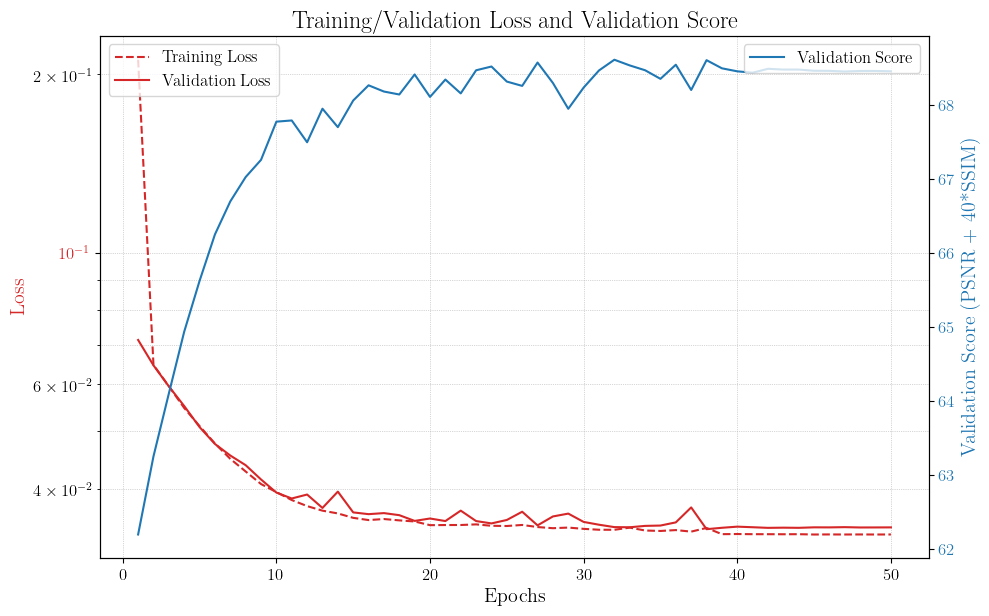

In [28]:
# TensorBoard Writer Setup
# Creates a subdirectory based on current time for each run
log_subdir = datetime.now().strftime('%Y%m%d-%H%M%S')
writer = SummaryWriter(log_dir=os.path.join(TENSORBOARD_LOG_DIR, log_subdir))
print(f"TensorBoard logs will be saved to: {os.path.join(TENSORBOARD_LOG_DIR, log_subdir)}")

# Model
model = TrivialNet().to(DEVICE)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# LR Scheduler
scheduler = ReduceLROnPlateau(optimizer,
                              mode='max', # Maximize validation score
                              factor=SCHEDULER_FACTOR,
                              patience=SCHEDULER_PATIENCE,
                              threshold=SCHEDULER_THRESHOLD,
                              min_lr=SCHEDULER_MIN_LR,
                              verbose=True)

# Loss Function (Criterion)
criterion = CombinedLoss(alpha=LOSS_ALPHA, data_range=1.0).to(DEVICE)

# Train the model
train_model(model, optimizer, scheduler, criterion, train_loader, val_loader, NUM_EPOCHS, MODEL_SAVE_PATH, writer)

### Evaluate the Best Model on a Validation Image Example


--- Evaluating Best Model on Example Validation Image ---
Loaded best model weights from best_model.pth

Metrics for Example Image (Index 0):
  PSNR: 31.73 dB
  SSIM: 0.9566
  Score (PSNR + 40*SSIM): 70.0003


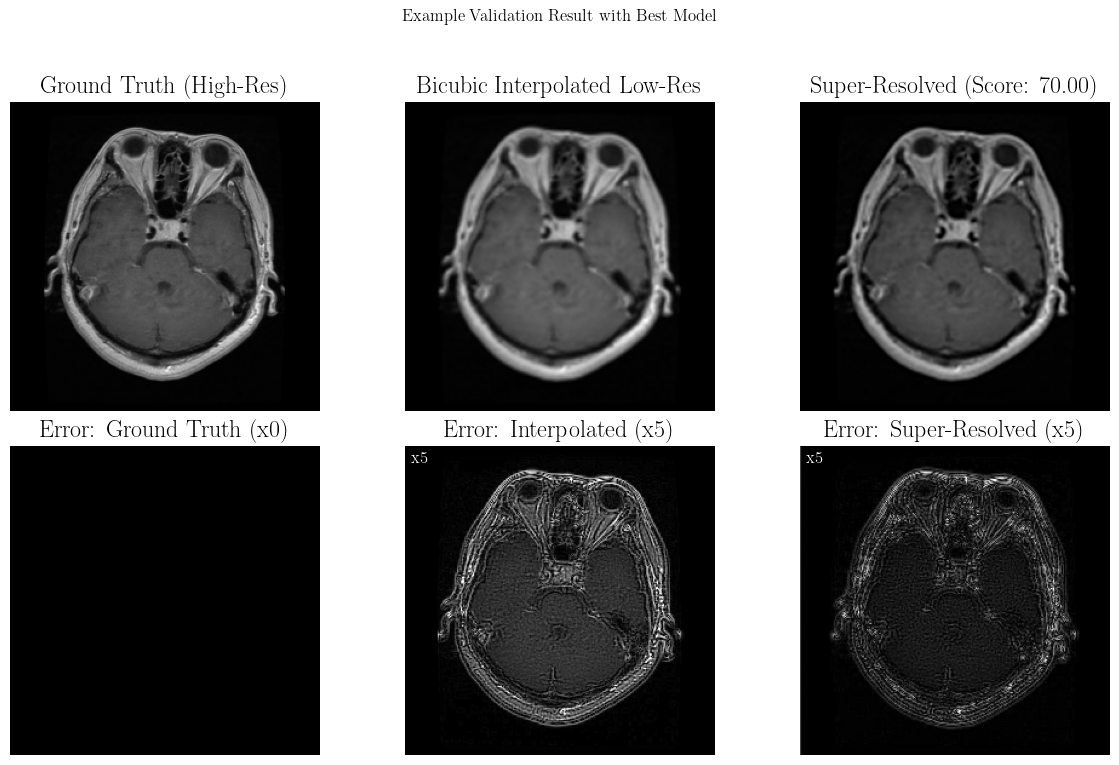

In [29]:
print("\n--- Evaluating Best Model on Example Validation Image ---")

# Load the best model weights
best_model = TrivialNet().to(DEVICE)
try:
    best_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    best_model.eval()
    print(f"Loaded best model weights from {MODEL_SAVE_PATH}")
except FileNotFoundError:
    print(f"Error: Best model file '{MODEL_SAVE_PATH}' not found. Skipping example evaluation.")
    # In this case, best_model remains the newly initialized TrivialNet, which is not trained.
    # Consider loading the 'model' variable which holds the last state if you want to see *something*.
    best_model = model # Fallback to the last state (might not be the best)
except Exception as e:
     print(f"Error loading model weights: {e}. Skipping example evaluation.")
     best_model = model

# Load one validation image pair (using index 0 as example)
try:
    # Get sample directly using the dataset's __getitem__
    val_low_res, val_high_res = val_dataset[0]
    val_low_res, val_high_res = val_low_res.to(DEVICE), val_high_res.to(DEVICE)

    # Prepare inputs (add batch dim, interpolate low-res)
    val_low_res_batch = val_low_res.unsqueeze(0)
    val_high_res_batch = val_high_res.unsqueeze(0)
    val_low_res_interpolated = F.interpolate(val_low_res_batch, scale_factor=2, mode='bicubic', align_corners=False)

    # Apply the best model
    with torch.no_grad():
        val_super_res_batch = best_model(val_low_res_interpolated)

    # Calculate metrics for this example
    ex_psnr, ex_ssim, ex_score = calculate_metrics(val_super_res_batch, val_high_res_batch)
    print(f"\nMetrics for Example Image (Index 0):")
    print(f"  PSNR: {ex_psnr:.2f} dB")
    print(f"  SSIM: {ex_ssim:.4f}")
    print(f"  Score (PSNR + 40*SSIM): {ex_score:.4f}")

    # Convert tensors to numpy for visualization
    val_low_res_np = val_low_res_interpolated.squeeze().cpu().numpy()
    val_high_res_np = val_high_res_batch.squeeze().cpu().numpy()
    val_super_res_np = val_super_res_batch.squeeze().cpu().numpy()

    # Plotting
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle("Example Validation Result with Best Model")
    im_opts = {'cmap': 'gray', 'vmin': 0, 'vmax': 1}
    err_opts = {'cmap': 'gray', 'vmin': 0, 'vmax': 1}
    err_scale = 5

    ax[0, 0].imshow(val_high_res_np, **im_opts)
    ax[0, 0].set_title('Ground Truth (High-Res)')
    ax[0, 1].imshow(val_low_res_np, **im_opts)
    ax[0, 1].set_title('Bicubic Interpolated Low-Res')
    ax[0, 2].imshow(val_super_res_np, **im_opts)
    ax[0, 2].set_title(f'Super-Resolved (Score: {ex_score:.2f})')

    err_gt_interp = err_scale * np.abs(val_high_res_np - val_low_res_np)
    err_gt_superres = err_scale * np.abs(val_high_res_np - val_super_res_np)
    ax[1, 0].imshow(np.zeros_like(val_high_res_np), **err_opts) # Zero error for ground truth vs itself
    ax[1, 0].set_title('Error: Ground Truth (x0)')
    ax[1, 1].imshow(err_gt_interp, **err_opts)
    ax[1, 1].set_title(f'Error: Interpolated (x{err_scale})')
    ax[1, 2].imshow(err_gt_superres, **err_opts)
    ax[1, 2].set_title(f'Error: Super-Resolved (x{err_scale})')

    for r in range(2):
        for c in range(3):
            ax[r, c].axis('off')
            if r == 1 and c > 0: # Add scale text only to error maps
                 ax[r, c].text(0.02, 0.98, f'x{err_scale}', transform=ax[r, c].transAxes, fontsize=12, va='top', ha='left', color='white', bbox=dict(facecolor='black', alpha=0.5, pad=0.1))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except IndexError:
     print("Error: Not enough images in validation dataset to display example index 0.")
except Exception as e:
     print(f"An error occurred during example evaluation visualization: {e}")
     traceback.print_exc()


### Final Evaluation on Full Validation Set with Best Model

In [30]:
print("\n--- Evaluating Best Model on Full Validation Set ---")

# Ensure the best model is loaded and in eval mode
if 'best_model' in locals() and isinstance(best_model, nn.Module):
    # Make sure the model used for final eval is actually the best one loaded
    # If loading failed, best_model might be the last state or untrained
    try:
        # Attempt to load again just to be sure, or use a flag
        state_dict = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
        best_model.load_state_dict(state_dict)
        best_model.eval()
        print(f"Using best model weights from {MODEL_SAVE_PATH} for final evaluation.")
    except Exception as e:
        print(f"Warning: Could not reload best model state for final evaluation ({e}). Using current 'best_model' state.")
        best_model.eval() # Ensure it's in eval mode anyway

    final_val_loss, final_psnr, final_ssim, final_score = validate_model(best_model, val_loader, criterion)

    print(f"\nFinal Metrics using Best Model on Validation Set:")
    print(f"  Average PSNR: {final_psnr:.2f} dB")
    print(f"  Average SSIM: {final_ssim:.4f}")
    print(f"  Average Score (PSNR + 40*SSIM): {final_score:.4f}")
    print(f"  Average Validation Loss: {final_val_loss:.6f}")

    # Reference Interpolation Metrics (Recalculate for clarity)
    print("\nFor Reference (metrics for simple Bicubic Interpolation on Validation Set):")
    ref_psnr_total, ref_ssim_total, ref_score_total, ref_samples = 0.0, 0.0, 0.0, 0
    with torch.no_grad():
        for batch in val_loader:
            if batch is None or len(batch) != 2: continue
            low_res_batch_ref, high_res_batch_ref = batch
            if low_res_batch_ref is None or high_res_batch_ref is None: continue

            batch_size_ref = low_res_batch_ref.size(0)
            low_res_batch_ref, high_res_batch_ref = low_res_batch_ref.to(DEVICE), high_res_batch_ref.to(DEVICE)
            low_res_interpolated_ref = F.interpolate(low_res_batch_ref, scale_factor=2, mode='bicubic', align_corners=False)
            psnr_ref, ssim_ref, score_ref = calculate_metrics(low_res_interpolated_ref, high_res_batch_ref)

            if score_ref != float('inf'):
                ref_psnr_total += psnr_ref * batch_size_ref
                ref_ssim_total += ssim_ref * batch_size_ref
                ref_score_total += score_ref * batch_size_ref
                ref_samples += batch_size_ref

    if ref_samples > 0:
        print(f"  Interpolation Average PSNR: {ref_psnr_total / ref_samples:.2f} dB")
        print(f"  Interpolation Average SSIM: {ref_ssim_total / ref_samples:.4f}")
        print(f"  Interpolation Average Score: {ref_score_total / ref_samples:.4f}")
    else:
        print("Could not calculate reference interpolation metrics (no valid samples).")

else:
    print("Best model not available for final evaluation.")

print("\n--- Script End ---")


--- Evaluating Best Model on Full Validation Set ---
Using best model weights from best_model.pth for final evaluation.

Final Metrics using Best Model on Validation Set:
  Average PSNR: 31.33 dB
  Average SSIM: 0.9319
  Average Score (PSNR + 40*SSIM): 68.6053
  Average Validation Loss: 0.034463

For Reference (metrics for simple Bicubic Interpolation on Validation Set):
  Interpolation Average PSNR: 25.46 dB
  Interpolation Average SSIM: 0.9008
  Interpolation Average Score: 61.4928

--- Script End ---
